# Assignment 1

- Connect to the database to get the data and do the analysis. 
- Perform a basic statistical analysis of the time DOT 311 (table is called dot_311) complaints are open (subtract closed date from created date)
- Submit the code through Github and type up your results in your PR.

In [1]:
import pandas as pd
import pg8000
from datetime import datetime
import numpy as np
import matplotlib
%matplotlib inline

## Preparing the data

In [2]:
# Set up the database
conn = pg8000.connect(host='training.c1erymiua9dx.us-east-1.rds.amazonaws.com', port=5432, database='training', user='dot_student', password='qgis')

In [3]:
# Rollback database connection in case of problems
conn.rollback()

In [4]:
# Getting the data from the database
cursor = conn.cursor()
db = list()
cursor.execute("SELECT * FROM dot_311")
for item in cursor.fetchall():
    db.append(item)

In [5]:
# Getting the headers from the database
cursor.execute("SELECT column_name FROM information_schema.columns WHERE table_name='dot_311'")
header = list()
for item in cursor.fetchall():
    header.append(item[0])

In [6]:
# Creating the Pandas Dataframe
df = pd.DataFrame(data=db)

In [7]:
# Substituting the column names
df.columns = header

In [8]:
df.head()

,gid,unique_key,agency,agency nam,complaint,descriptor,location t,incident z,incident a,street nam,...,bridge h_2,garage lot,ferry dire,ferry term,latitude,longitude,location,geom,created_date,closed_date
0,2,32570549,DOT,Department of Transportation,Traffic Signal Condition,Controller,None,10301,None,None,...,None,None,None,None,40.613803753157917,-74.113373738864198,"(40.61380375315792, -74.1133737388642)",0101000020E61000006829ED83418752C0D7FC121F914E...,2016-02-01 00:12:00,2016-02-01 01:15:00
1,3,32572958,DOT,Department of Transportation,Traffic Signal Condition,Controller,None,10301,None,None,...,None,None,None,None,40.626545297464929,-74.091582334480577,"(40.62654529746493, -74.09158233448058)",0101000020E610000011DF267CDC8552C08809E5A23250...,2016-02-01 00:14:00,2016-02-01 00:54:00
2,4,32573576,DOT,Department of Transportation,Traffic Signal Condition,Controller,None,10310,None,None,...,None,None,None,None,40.629249554787492,-74.123220752604595,"(40.62924955478749, -74.1232207526046)",0101000020E610000004A84BD9E28752C0DC6AD93F8B50...,2016-02-01 00:15:00,2016-02-01 01:30:00
3,5,32572389,DOT,Department of Transportation,Traffic Signal Condition,Controller,None,None,None,None,...,None,None,None,None,None,None,None,0101000020E610000004A84BD9E28752C0DC6AD93F8B50...,2016-02-01 00:17:00,2016-02-01 02:35:00
4,6,32570548,DOT,Department of Transportation,Traffic Signal Condition,Controller,None,None,None,None,...,None,None,None,None,None,None,None,0101000020E610000004A84BD9E28752C0DC6AD93F8B50...,2016-02-01 00:19:00,2016-02-01 01:00:00


In [9]:
df[['created_date', 'closed_date',]].head(5)

,created_date,closed_date
0,2016-02-01 00:12:00,2016-02-01 01:15:00
1,2016-02-01 00:14:00,2016-02-01 00:54:00
2,2016-02-01 00:15:00,2016-02-01 01:30:00
3,2016-02-01 00:17:00,2016-02-01 02:35:00
4,2016-02-01 00:19:00,2016-02-01 01:00:00


In [10]:
# Creating a new column with the time elapsed betweedn creation of the ticket and its closing. 
df['time_elapsed'] = df['closed_date'] - df['created_date']
df[['created_date', 'closed_date', 'time_elapsed']].head(5)

,created_date,closed_date,time_elapsed
0,2016-02-01 00:12:00,2016-02-01 01:15:00,01:03:00
1,2016-02-01 00:14:00,2016-02-01 00:54:00,00:40:00
2,2016-02-01 00:15:00,2016-02-01 01:30:00,01:15:00
3,2016-02-01 00:17:00,2016-02-01 02:35:00,02:18:00
4,2016-02-01 00:19:00,2016-02-01 01:00:00,00:41:00


In [13]:
# It takes time to process a request. Unfortunately, there are negative values in the dataset. That's not possible in reality...
# Let's check how many times are negative. 
df[df['time_elapsed'] < '00:00:00']['unique_key'].count()

582

In [12]:
# Let's check how many items with 'normal' timestamps are in the dataset. 
df['unique_key'].count()

5851

In [219]:
# There are also a lot of tickets that have been opened and closed at the same time. 
df[df['time_elapsed'] == '00:00:00']['unique_key'].count()

521

In [220]:
# What percentage of the times are wrong? 
100 * df[df['time_elapsed'] <= '00:00:00']['unique_key'].count() / df['unique_key'].count()

18.851478379764142

In [53]:
# Every fith entry seems to be strange. That is a lot. If the wrong ones are filled randomly, 
# we could go on. If most of them are from the same department or about the same topic, 
# we would have to think about it.
print("This are all complaint categories:\n\n", df['complaint'].value_counts())
wrong = df[df['time_elapsed'] <= '00:00:00']

print("This are the categories affected by non plausible values:\n\n", wrong['complaint'].value_counts(), "\n\n")
print("In the category Street Light Condition", 100 * wrong[wrong['complaint'] == 'Street Light Condition']['complaint'].value_counts() / df[df['complaint'] == 'Street Light Condition']['complaint'].value_counts(), "percent are wrong.")

This are all complaint categories:

 Street Light Condition        2040
Street Condition              1916
Traffic Signal Condition       808
Broken Muni Meter              525
Sidewalk Condition             106
Highway Condition               90
Street Sign - Damaged           83
Street Sign - Missing           67
Street Sign - Dangling          55
DOT Literature Request          53
Broken Parking Meter            32
Curb Condition                  21
Bridge Condition                18
Ferry Inquiry                   13
Ferry Complaint                  7
Bus Stop Shelter Placement       7
Highway Sign - Damaged           4
Municipal Parking Facility       3
Public Toilet                    2
Parking Card                     1
Name: complaint, dtype: int64
This are the categories affected by non plausible values:

 Street Light Condition      968
Street Condition            134
Traffic Signal Condition      1
Name: complaint, dtype: int64 


In the category Street Light Condition Stree

In [56]:
# About half of the entries about "Street Light Condition" is wrong. Let's exclude these from our analysis.
# We also exclude the other wrong data. We need to mention it in our article, though.

df_plausible = df[df['complaint'] != 'Street Light Condition']
df_plausible = df_plausible[df_plausible['time_elapsed'] > '00:00:00']
df.head(3)

,gid,unique_key,agency,agency nam,complaint,descriptor,location t,incident z,incident a,street nam,...,garage lot,ferry dire,ferry term,latitude,longitude,location,geom,created_date,closed_date,time_elapsed
0,2,32570549,DOT,Department of Transportation,Traffic Signal Condition,Controller,None,10301,None,None,...,None,None,None,40.613803753157917,-74.113373738864198,"(40.61380375315792, -74.1133737388642)",0101000020E61000006829ED83418752C0D7FC121F914E...,2016-02-01 00:12:00,2016-02-01 01:15:00,01:03:00
1,3,32572958,DOT,Department of Transportation,Traffic Signal Condition,Controller,None,10301,None,None,...,None,None,None,40.626545297464929,-74.091582334480577,"(40.62654529746493, -74.09158233448058)",0101000020E610000011DF267CDC8552C08809E5A23250...,2016-02-01 00:14:00,2016-02-01 00:54:00,00:40:00
2,4,32573576,DOT,Department of Transportation,Traffic Signal Condition,Controller,None,10310,None,None,...,None,None,None,40.629249554787492,-74.123220752604595,"(40.62924955478749, -74.1232207526046)",0101000020E610000004A84BD9E28752C0DC6AD93F8B50...,2016-02-01 00:15:00,2016-02-01 01:30:00,01:15:00


In [57]:
# To be able to plot it, we will add a new column with the time converted to minutes. 
df_plausible['time_elapsed_minutes'] = df_plausible['time_elapsed'].apply(lambda x: x / np.timedelta64(1,'m'))
df_plausible[['time_elapsed', 'time_elapsed_minutes']].head()

,time_elapsed,time_elapsed_minutes
0,01:03:00,63.0
1,00:40:00,40.0
2,01:15:00,75.0
3,02:18:00,138.0
4,00:41:00,41.0


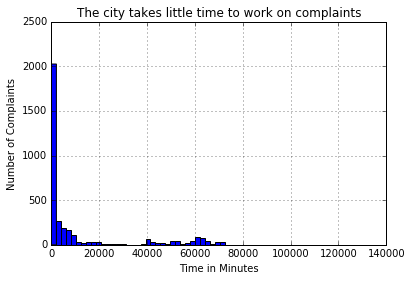

In [80]:
# Let's get an overview by plotting it.
ax = df_plausible['time_elapsed_minutes'].hist(bins=60)
ax.set_title("The city takes little time to work on complaints")
ax.set_xlabel("Time in Minutes")
ax.set_ylabel("Number of Complaints")

In [82]:
# How long does it them take to close a complaint? Let's check the mean, the quartiles, the min and max.
df_plausible['time_elapsed'].describe()

count                       3564
mean      8 days 14:30:00.796857
std      14 days 23:30:11.891432
min              0 days 00:00:01
25%       0 days 12:19:35.250000
50%       1 days 02:57:40.500000
75%       5 days 21:13:29.500000
max             86 days 06:08:31
Name: time_elapsed, dtype: object

In [83]:
# Since we don't nearly havee a bell shaped curve, we probably better use the median instead of the mean. 
df_plausible['time_elapsed'].median()

Timedelta('1 days 02:57:40.500000')

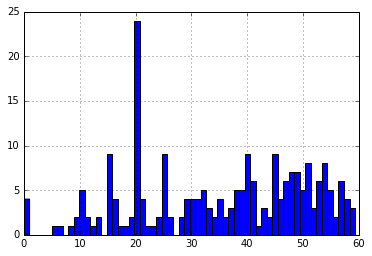

In [84]:
# Let's just look at the complaints that were closed in the first hour after their opening.
df_plausible[df_plausible['time_elapsed_minutes'] < 60]['time_elapsed_minutes'].hist(bins=60)

In [87]:
# Let's check what types of complaints take the longest and the shortest to getting closed.
df_plausible.groupby(by='complaint')['time_elapsed_minutes'].median().sort_values()

complaint
Traffic Signal Condition        122.000000
Public Toilet                   492.200000
Highway Condition              1449.116667
DOT Literature Request         1529.750000
Street Condition               1556.266667
Bridge Condition               2453.916667
Ferry Inquiry                  2457.866667
Bus Stop Shelter Placement     2655.233333
Sidewalk Condition             2841.466667
Ferry Complaint                3270.833333
Curb Condition                 5022.966667
Street Sign - Missing          8219.400000
Street Sign - Damaged          8883.433333
Street Sign - Dangling         9392.458333
Highway Sign - Damaged        25954.566667
Parking Card                  35793.000000
Municipal Parking Facility    40212.333333
Broken Muni Meter             58977.233333
Broken Parking Meter          60230.033333
Name: time_elapsed_minutes, dtype: float64

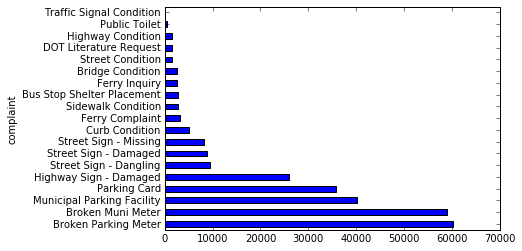

In [96]:
# Let's plot that.
df_plausible.groupby(by='complaint')['time_elapsed_minutes'].median().sort_values(ascending=False).plot(kind='barh', legend=False)

In [101]:
df_plausible[df_plausible['complaint'] == 'Traffic Signal Condition']['time_elapsed'].median()

Timedelta('0 days 02:02:00')

In [102]:
df_plausible[df_plausible['complaint'] == 'Public Toilet']['time_elapsed'].median()

Timedelta('0 days 08:12:12')

In [103]:
df_plausible[df_plausible['complaint'] == 'Broken Parking Meter']['time_elapsed'].median()

Timedelta('41 days 19:50:02')